In [1]:
import pandas as pd
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from numpy import mean
from numpy import std
from xgboost import XGBRegressor
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pyfolio
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from datalayer import get_train_data
from plot_curves import plot_learning_curve
from utils import create_lags


%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/helderrezende/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


## Data analysis

No caso, escolhi um tempo de 7 dias uteis para rodar o modelo, não teve algum motivo importante. Eu cheguei a rodar com 14 dias uteis, porém com 7 dias teve um resultado melhor.

In [2]:
data = get_train_data(resample_time="7B")

data.head()

,ibov,spx,uc1,br_econ_uncert
ref_date,,,,
2000-02-09,-0.037792,-0.037081,0.002534,0.000000
2000-02-18,-0.024289,-0.028964,-0.001124,0.000000
2000-02-29,0.042196,0.013835,-0.013780,-0.244322
2000-03-09,-0.042208,0.071537,-0.004277,0.000000
2000-03-20,0.047207,0.029540,-0.001432,0.000000


In [3]:
data.tail()

,ibov,spx,uc1,br_econ_uncert
ref_date,,,,
2019-11-19,0.013536,0.010122,0.010904,0.0
2019-11-28,0.031734,-0.002448,-0.027905,0.0
2019-12-09,0.013407,0.014816,-0.018574,0.0
2019-12-18,0.040736,0.014844,-0.002949,0.0
2019-12-27,-0.013292,-0.005747,-0.006286,0.0


Para evitar o look-ahead bias, irei criar variaveis com lag.

In [4]:
data = create_lags(data, columns=['spx', 'uc1', 'br_econ_uncert'])

In [5]:
data = data.drop(columns=['spx', 'uc1', 'br_econ_uncert'])

data = data.dropna()

#### Creating train and test data

Resolvi excluir os anos de 2018 e 2019 usá-los como teste no backtesting.

In [6]:
train_data = data.loc[:pd.to_datetime('2017-12-31')]
test_data = data.loc[pd.to_datetime('2017-12-31'):]

In [7]:
train_data.head()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1
ref_date,,,,
2000-02-18,-0.024289,-0.037081,0.002534,0.000000
2000-02-29,0.042196,-0.028964,-0.001124,0.000000
2000-03-09,-0.042208,0.013835,-0.013780,-0.244322
2000-03-20,0.047207,0.071537,-0.004277,0.000000
2000-03-29,-0.064989,0.029540,-0.001432,0.000000


In [8]:
test_data.head()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1
ref_date,,,,
2018-01-02,0.023540,0.001106,-0.000906,0.000000
2018-01-11,0.038605,0.022582,-0.021164,0.000000
2018-01-22,0.040175,0.022585,-0.010965,0.000000
2018-01-31,-0.034918,0.004316,-0.006246,0.000000
2018-02-09,0.036698,-0.085540,0.035041,-0.410405


**Correlation**

In [9]:
train_data.corr()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1
ibov,1.000000,0.076215,0.051583,-0.021437
spx_lag1,0.076215,1.000000,-0.357531,-0.060074
uc1_lag1,0.051583,-0.357531,1.000000,0.101374
br_econ_uncert_lag1,-0.021437,-0.060074,0.101374,1.000000


### Ibov analysis

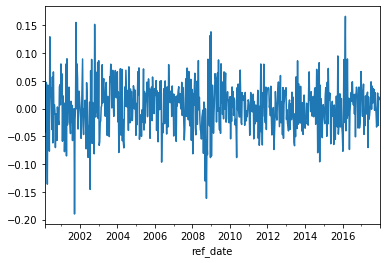

In [10]:
train_data['ibov'].plot()

#### Looking autocorrelation

É comum as séries históricas de preço ter autocorrelação, então vale a pena diagnosticar o ibov.

##### Autocorrelation

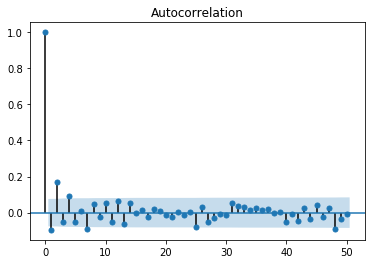

In [11]:
plot_acf(train_data['ibov'].values, lags=50);

##### Partial autocorrelation

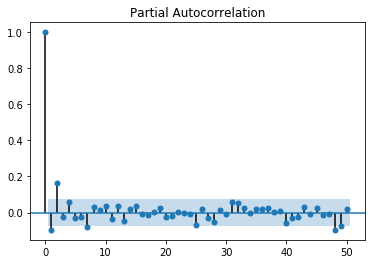

In [12]:
plot_pacf(train_data['ibov'].values, lags=50);

Ao observar os dois plot, além do lag1 do ibov, também vou utilizar o lag2 do ibov como feature.

### Features

#### Creating date features

Criando uma simples feature do mês corrente.

In [13]:
train_data['month'] = train_data.reset_index()['ref_date'].dt.month.values
test_data['month'] = test_data.reset_index()['ref_date'].dt.month.values

A feature do lag2 do ibov

In [14]:
data['ibov_lag2'] = data['ibov'].shift(2)

In [15]:
train_data['ibov_lag2'] = data['ibov_lag2'].loc[:pd.to_datetime('2017-12-31')]
train_data = train_data.dropna()
test_data['ibov_lag2'] = data['ibov_lag2'].loc[pd.to_datetime('2017-12-31'):]

In [16]:
train_data.head()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1,month,ibov_lag2
ref_date,,,,,,
2000-03-09,-0.042208,0.013835,-0.013780,-0.244322,3,-0.024289
2000-03-20,0.047207,0.071537,-0.004277,0.000000,3,0.042196
2000-03-29,-0.064989,0.029540,-0.001432,0.000000,3,-0.042208
2000-04-07,-0.135917,-0.004238,0.007743,0.784052,4,0.047207
2000-04-18,0.042568,-0.066541,0.013660,0.000000,4,-0.064989


### Model

In [17]:
X = train_data.drop('ibov', axis=1).values 
y = train_data['ibov'].values

#### Perfomance 

Rodando o modelo para ver a perfomance utilizando o RepeatedKFold e valores padrões.

In [18]:
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

In [19]:
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

MAE: -0.034 (0.003)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

#### Tunning Parameters

Achando os parametros ótimos com GridSearchCV

In [20]:
params = {
        'min_child_weight': [1, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [3, 4, 5]}


kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(model, params, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X, y)

Fitting 30 folds for each of 24 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    4.6s finished


In [21]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.001874 using {'colsample_bytree': 0.8, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}


#### Learning Curve

Nesta etapa vou utilizar a learning curve para diagnosticar um possível overfit ou underfit do modelo.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
model = XGBRegressor(objective='reg:squarederror')
eval_set = [(X_train, y_train), (X_test, y_test)]
grid_result.best_estimator_.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.449224	validation_1-rmse:0.449722
[1]	validation_0-rmse:0.404811	validation_1-rmse:0.405338
[2]	validation_0-rmse:0.364873	validation_1-rmse:0.365434
[3]	validation_0-rmse:0.32897	validation_1-rmse:0.329568
[4]	validation_0-rmse:0.296703	validation_1-rmse:0.297342
[5]	validation_0-rmse:0.267717	validation_1-rmse:0.2684
[6]	validation_0-rmse:0.241689	validation_1-rmse:0.242422
[7]	validation_0-rmse:0.218331	validation_1-rmse:0.219119
[8]	validation_0-rmse:0.197385	validation_1-rmse:0.198232
[9]	validation_0-rmse:0.178617	validation_1-rmse:0.179529
[10]	validation_0-rmse:0.161818	validation_1-rmse:0.162801
[11]	validation_0-rmse:0.146801	validation_1-rmse:0.14786
[12]	validation_0-rmse:0.13339	validation_1-rmse:0.134534
[13]	validation_0-rmse:0.121431	validation_1-rmse:0.12267
[14]	validation_0-rmse:0.11077	validation_1-rmse:0.112139
[15]	validation_0-rmse:0.101287	validation_1-rmse:0.102789
[16]	validation_0-rmse:0.092865	validation_1-rmse:0.094513
[17]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, verbosity=1)

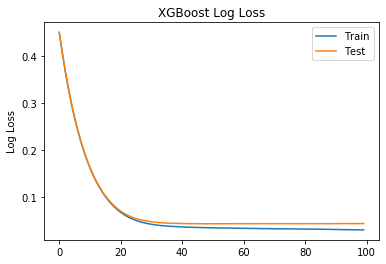

In [23]:
plot_learning_curve(grid_result.best_estimator_)

Podemos percever que por volta da etapa 30 a 50 o erro do test não diminui tanto. Para evitar um overfit, vou utilizar o early_stopping_rounds.

using early_stopping_rounds 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model no training data
model = XGBRegressor(objective='reg:squarederror')
eval_set = [(X_train, y_train), (X_test, y_test)]
grid_result.best_estimator_.fit(X_train, y_train, early_stopping_rounds=1, eval_metric=["rmse"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.449224	validation_1-rmse:0.449722
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1 rounds.
[1]	validation_0-rmse:0.404811	validation_1-rmse:0.405338
[2]	validation_0-rmse:0.364873	validation_1-rmse:0.365434
[3]	validation_0-rmse:0.32897	validation_1-rmse:0.329568
[4]	validation_0-rmse:0.296703	validation_1-rmse:0.297342
[5]	validation_0-rmse:0.267717	validation_1-rmse:0.2684
[6]	validation_0-rmse:0.241689	validation_1-rmse:0.242422
[7]	validation_0-rmse:0.218331	validation_1-rmse:0.219119
[8]	validation_0-rmse:0.197385	validation_1-rmse:0.198232
[9]	validation_0-rmse:0.178617	validation_1-rmse:0.179529
[10]	validation_0-rmse:0.161818	validation_1-rmse:0.162801
[11]	validation_0-rmse:0.146801	validation_1-rmse:0.14786
[12]	validation_0-rmse:0.13339	validation_1-rmse:0.134534
[13]	validation_0-rmse:0.121431	validation_1-rmse:0.12267
[14]	validation_0-rmse:0.11077	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, verbosity=1)

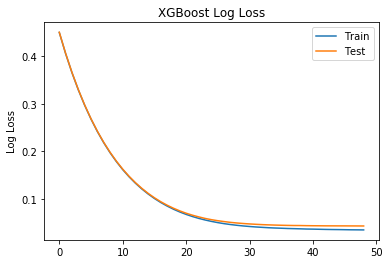

In [25]:
plot_learning_curve(grid_result.best_estimator_)

Com o early_stopping_rounds  foi possível "stopar" para diminuir a chance do overfit.

### Result analysis

#### Usando dados de 2000 até 2017 para prever 2018 e 2019.

In [28]:
train_data.head()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1,month,ibov_lag2
ref_date,,,,,,
2000-03-09,-0.042208,0.013835,-0.013780,-0.244322,3,-0.024289
2000-03-20,0.047207,0.071537,-0.004277,0.000000,3,0.042196
2000-03-29,-0.064989,0.029540,-0.001432,0.000000,3,-0.042208
2000-04-07,-0.135917,-0.004238,0.007743,0.784052,4,0.047207
2000-04-18,0.042568,-0.066541,0.013660,0.000000,4,-0.064989


In [29]:
test_data['predicted_values'] = grid_result.best_estimator_.predict(test_data.drop(columns=['ibov']).values)

In [30]:
test_data.head()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1,month,ibov_lag2,predicted_values
ref_date,,,,,,,
2018-01-02,0.023540,0.001106,-0.000906,0.000000,1,0.017882,0.005037
2018-01-11,0.038605,0.022582,-0.021164,0.000000,1,0.016885,0.005210
2018-01-22,0.040175,0.022585,-0.010965,0.000000,1,0.023540,0.002776
2018-01-31,-0.034918,0.004316,-0.006246,0.000000,1,0.038605,0.002698
2018-02-09,0.036698,-0.085540,0.035041,-0.410405,2,0.040175,-0.017431


In [31]:
test_data.tail()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1,month,ibov_lag2,predicted_values
ref_date,,,,,,,
2019-11-19,0.013536,0.011944,0.028025,0.0,11,0.018821,0.006220
2019-11-28,0.031734,0.010122,0.010904,0.0,11,-0.030218,0.015961
2019-12-09,0.013407,-0.002448,-0.027905,0.0,12,0.013536,0.011878
2019-12-18,0.040736,0.014816,-0.018574,0.0,12,0.031734,0.012923
2019-12-27,-0.013292,0.014844,-0.002949,0.0,12,0.013407,0.011842


### Simple backtest

Usando a lógica simples de que se o modelo prever um retorno maior que zero, o trader deve tomar a posição long. Caso contrário deve tomar a posição short.

In [32]:
test_data['pos'] = np.where(test_data['predicted_values'] > 0.0 , 1, -1)

Para calcular o retorno basta multiplicar a posição pelo retorno do ibov suponto que 100% do capital está alocado em ibov.

In [33]:
test_data['return_by_model'] = test_data['ibov'] * test_data['pos']

In [34]:
test_data.head()

,ibov,spx_lag1,uc1_lag1,br_econ_uncert_lag1,month,ibov_lag2,predicted_values,pos,return_by_model
ref_date,,,,,,,,,
2018-01-02,0.023540,0.001106,-0.000906,0.000000,1,0.017882,0.005037,1,0.023540
2018-01-11,0.038605,0.022582,-0.021164,0.000000,1,0.016885,0.005210,1,0.038605
2018-01-22,0.040175,0.022585,-0.010965,0.000000,1,0.023540,0.002776,1,0.040175
2018-01-31,-0.034918,0.004316,-0.006246,0.000000,1,0.038605,0.002698,1,-0.034918
2018-02-09,0.036698,-0.085540,0.035041,-0.410405,2,0.040175,-0.017431,-1,-0.036698


#### Backtesting results

Análisando o resultado do backtests com o pyfolio

Start date,2018-01-02
End date,2019-12-27
Total months,3
,Backtest
Annual return,1226.1%
Cumulative returns,115.8%
Annual volatility,46.5%
Sharpe ratio,5.82
Calmar ratio,116.43
Stability,0.92
Max drawdown,-10.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.53,2018-01-22,2018-04-30,2018-06-27,113
1,8.41,2018-07-26,2018-08-24,2018-12-31,113
2,3.56,2019-04-26,2019-05-07,2019-05-27,22
3,3.34,2019-09-20,2019-10-01,2019-10-21,22
4,3.02,2019-10-30,2019-11-08,2019-11-28,22


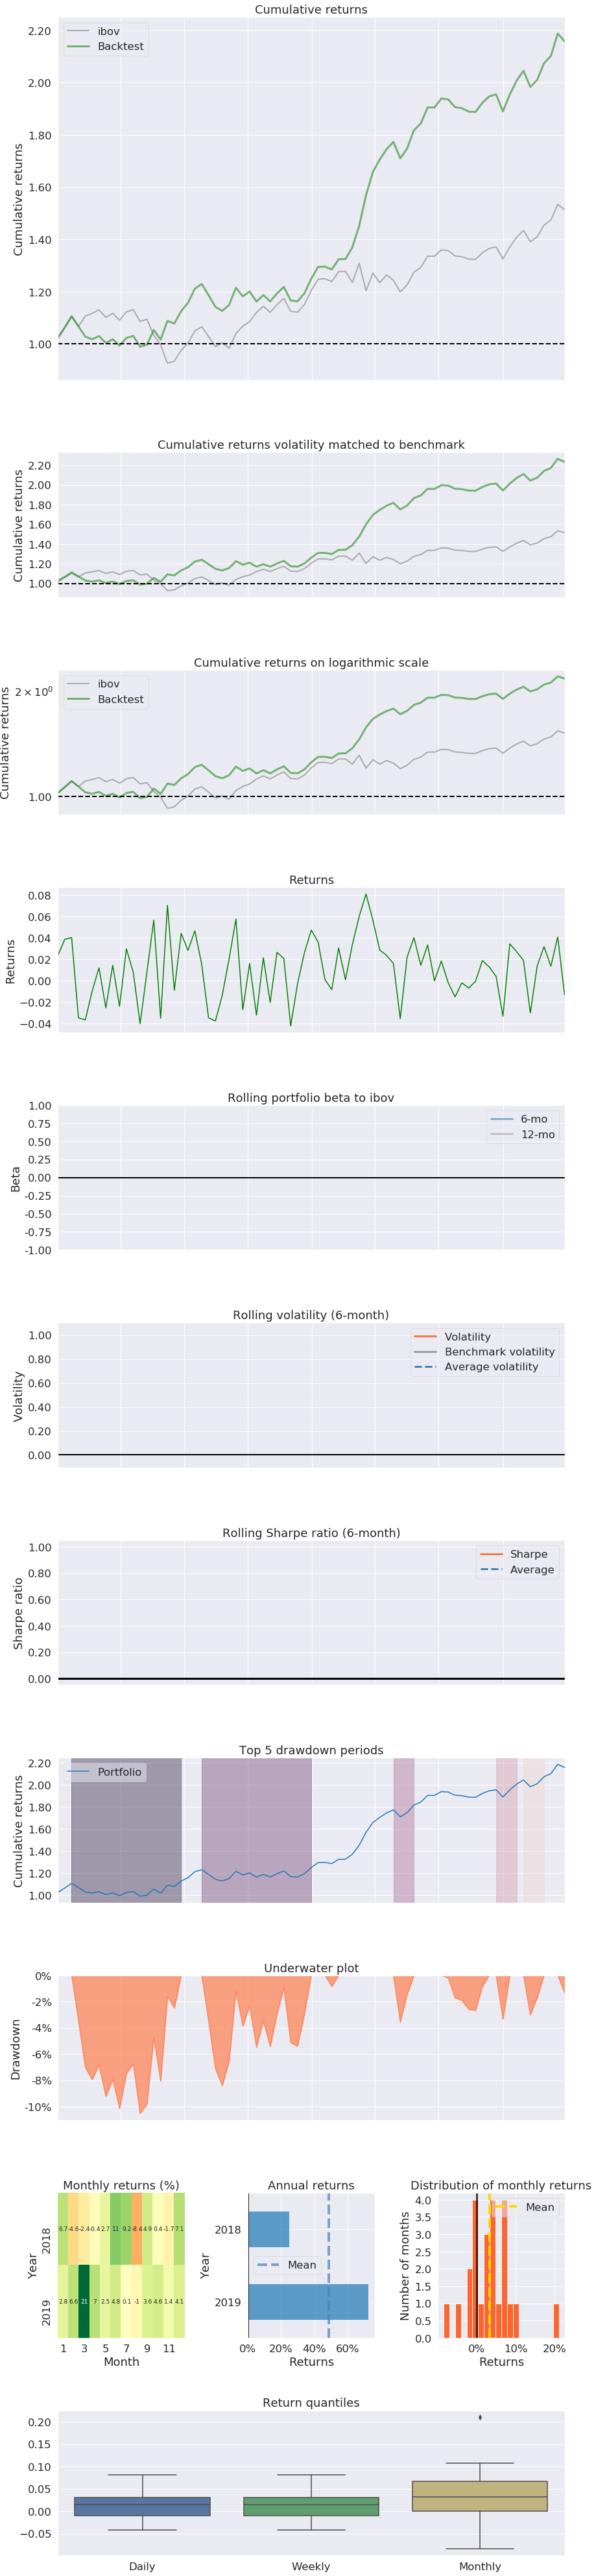

In [35]:
pyfolio.create_returns_tear_sheet(test_data['return_by_model'], benchmark_rets=test_data['ibov'])

No início do backteting o modelo foi pior que o ibovespa, mas no ano de 2019 foi bem melhor.

O ideal seria rodar o modelo para outras épocas, já que 2019 pode ser um ano atípico ou apenas sorte.

### Next steps

- Melhorar o código para achar os parametros ótimos. No caso eu coloquei um range bem pequeno no GridSearchCV para não perder muito tempo.


- Pensar numa maneira mais inteligente de assumir a posição long e short. Por exemplo, assumir long apenas quando o modelo prever um retorno maior que 1% ou alguma lógica parecida.


- Incluir mais dados no modelo.


- Testar outros modelos como LightGBM, Reinforcement learning e etc.


- Estruturar o código em arquivos py e estruturar uma rotina (Airflow) para atualizar o modelo todo dia.


- Entender melhor o resultado e rodar para outras janelas para ter mais certeza do modelo.